# Ecuaciones de elasticidad estática en 2D

Nota: a este documento no lo podremos ejecutar de manera dinámica con Binder, sólo lo podrán correr si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

Ejecutar este documento en forma dinámica: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/ElasticidadLineal2D.ipynb)



### Referencias
- Mark S. Gockenbach, [Understanding and Implementing the Finite Element Method](https://my.siam.org/Store/Product/viewproduct/?ProductId=997) (2006), Siam.
- También sacamos el ejemplo del siguiente [enlace](https://comet-fenics.readthedocs.io/).

Desarrollado por Jeremy Bleyer del Laboratoire Navier, ENPC, Université Gustave Eiffel, CNRS, "Numerical Tours of Computational Mechanics with FEniCS", DOI=10.5281/zenodo.1287832, Zenodo, 2018.

In [ ]:
%%capture  
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin


## Introducción y definiciones

En esta nota estudiaremos la respuesta mecánica de un medio isotrópico en dos dimensiones. Estaremos interesados en computar la variable que desconocemos, que es el desplazamiento $u$, y desarrollaremos el modelo en base a cuánto se deforma el medio (utilizaremos deformación $\varepsilon$ y tensión o esfuerzo $\sigma$).

### Ecuaciones de equilibrio de Cauchy 

Pensemos en un sólido elástico con un volumen $\Omega$ y sea $\omega$ una región arbitraria de ese sólido con bordes $\partial \omega$ y un vector normal a ese borde $n$. Hemos visto en ejemplos anteriores que sobre un sólido pueden actuar fuerzas denominadas **fuerza de cuerpo**, por ejemplo, la que utilizaremos más a menudo es el peso, que actuará en $\omega$ (en dos dimensiones será un vector $f=\left[0, -9,81 \right]^{T}$). También pueden actuar fuerzas en el borde $\partial\omega$, para esto necesariamente tendremos que definir el **tensor de tensiones $\sigma$** (tensor de segundo órden) y tendrán la forma $\sigma \cdot n$, cuyos componentes se pueden calcular con:

$$\left( \sigma \cdot n \right)_{i} = \sum_{j=1}^{3}\sigma_{ij} n_{j}  \tag{1}$$

Las componentes $\sigma_{ij}$ expresan la fuerza por unidad de longitud en 2D (en 3D por unidad de área) en la dirección $x_{i}$ sobre una superficie con dirección normal en la dirección de $x_{j}$. Para esclarecer, en la figura se ve un corte y el componente normal al plano $zy$ y las dos componentes tangenciales (pusimos como subíndices letras para que sea más fácil de ver). 

[<img src="figura3.png" width="250"/>](figura3.png)

Si planteamos equilibrio de rotación en tres planos perpendiculares entre si en una infinitesimal, entonces tendremos que las componentes $\tau_{ij}=\tau_{ji}$. Por lo tanto, este tensor tendrá sólo 6 componentes diferentes (independientes). Si sumamos el peso (integrando) y las fuerzas en los bordes (integrando en los bordes), tendremos la fuerza neta entonces:

$$F = \int_{\omega} f dx +  \int_{\partial\omega} \sigma\cdot n \ ds \tag{2}$$

Utilizando el teorema de la divergencia visto [antes](https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/fem2D.ipynb), podemos expresar Ec. (2) como:

$$F = \int_{\omega}\left( f + \nabla \cdot \sigma \right)\ dx \tag{3}$$

Si pensamos en un problema estático, la primera ley de Newton dice que la fuerza neta debe ser nula $F=0$, entonces:

$$f + \nabla \cdot \sigma = 0 \tag{4}$$

esta se denomina ecuación de equilibrio de Cauchy. **CUIDADO**: hay que remarcar que aquí calculamos la divergencia de un tensor cuyo resultado es un vector con las divergencias de cada fila del tensor.

La escribimos completa en 3D para que se vea:

$$ f_{1}+ \frac{\partial \sigma_{11}}{\partial x_{1}}+ \frac{\partial \sigma_{12}}{\partial x_{2}}+ \frac{\partial \sigma_{13}}{\partial x_{3}}=0\\ 
f_{2}+ \frac{\partial \sigma_{21}}{\partial x_{1}}+ \frac{\partial \sigma_{22}}{\partial x_{2}}+ \frac{\partial \sigma_{23}}{\partial x_{3}}=0\\  
f_{3}+ \frac{\partial \sigma_{31}}{\partial x_{1}}+ \frac{\partial \sigma_{32}}{\partial x_{2}}+ \frac{\partial \sigma_{33}}{\partial x_{3}}=0
$$

Ahora es conveniente definir el **desplazamiento $u$**. Si pensamos en 2D, supongamos que tenemos un punto que tiene coordenadas $\left(x,y\right)$, definimos el vector desplazamiento $u = \left[u_{1},u_{2}\right]^{T}$ (cada una de las componentes será una función de $x$ e $y$) de tal forma que el punto mencionado se traslada a $\left(x+u_{1}(x,y),y+u_{2}(x,y)\right)$. Bajo las condiciones de pequeños gradientes de desplazamientos se puede definir la **deformación** como el tensor:

$$\varepsilon = \frac{1}{2} \left( \nabla u + \nabla u^{T} \right) \tag{5}$$

cuyas componentes son:

$$\varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_{i}}{\partial x_{j}}+\frac{\partial u_{j}}{\partial x_{i}} \right) \tag{6}$$

para $i,j = 1,2,3$. Recordemos que debería ser invariante a la traslación y rotación, aunque esta última no se cumple totalmente. Sólo se cumple cuando las rotaciones son pequeñas.
Las componentes diagonales $\varepsilon_{ii}$ son los cambios relativos en longitud sobre el eje $x_{i}$. Los componentes $\varepsilon_{ij}$ son una magnitud proporcional al cambio de ángulo entre la coordenada del eje $x_{i}$ y el $x_{j}$, que inicialmente eran ortogonales.

### Ley de Hooke

Ahora veremos la relación entre tensiones, deformaciones y desplazamientos. Para un material elástico lineal e isotrópico, esto lo describe la ley de Hooke:

$$\sigma = 2\mu\varepsilon\left(u\right)+\lambda \left(\nabla \cdot u\right) I \tag{7}$$

donde $I$ es la matriz identidad de $3\times 3$. Los parámetros $\mu$ y $\lambda$ son los [**parámetros de Lamé**](https://es.wikipedia.org/wiki/Par%C3%A1metros_de_Lam%C3%A9):

$$\mu = \frac{E}{2\left(1+\nu\right)}\\
\lambda = \frac{E\nu}{\left(1+\nu\right)\left(1-2\nu\right)}\tag{8}$$

donde $E$ es el módulo de Young y $\nu$ es el coeficiente de Poisson. Ambos se consideran constantes en todo el material en todas las direcciones. Esta expresión también puede encontrarse en función de la deformación:

$$\sigma = 2\mu\varepsilon\left(u\right)+\lambda tr\left(\varepsilon\left(u\right)\right) I \tag{9}$$

## Ecuaciones de elasticidad lineal estática

Considerando todo lo anterior tenemos las ecuaciones de la formulación dura:

$$ \left \{ \begin{array}{l} - \nabla \cdot \sigma = f \ \ \text{ en } \ \ \Omega \\   \sigma = \lambda tr\left(\varepsilon\right)I+2\mu \varepsilon \\  
\varepsilon = \frac{1}{2} \left( \nabla u + \nabla u^{T} \right)
\end{array} \right . \tag{10}$$

con condiciones de borde en $\partial \Omega$, ya sea Dirichlet, Neumman o Robin.

---
**Cuidado:** Note que debe estar atento a algunas cosas:

- El gradiente del desplazamiento, por ejemplo en 2D, tendrá la forma:

$$ \nabla u = \begin{bmatrix} \frac{\partial u_{1}}{\partial x} & \frac{\partial u_{1}}{\partial y}\\ 
\frac{\partial u_{2}}{\partial x} & \frac{\partial u_{2}}{\partial y}\end{bmatrix}$$

- La divergencia de la tensión (seguimos en 2D) es:

$$ \nabla \cdot \sigma = \begin{bmatrix} \frac{\partial \sigma_{11}}{\partial x} + \frac{\partial \sigma_{12}}{\partial y}\\ 
\frac{\partial \sigma_{21}}{\partial x} + \frac{\partial \sigma_{22}}{\partial y}\end{bmatrix}$$


---

### Formulación variacional

Como hemos hecho hasta ahora, debemos expresar el problema en la formulación débil. Note que tanto $-\nabla \cdot \sigma $ como $f$ son vectores, por lo tanto la función test por la que multiplique también tendrá que ser un vector que vaya de $\Omega$ a $\mathbb{R}^{2}$. Si tomamos la Ec. (10) y multiplicamos por $v$ tendremos:

$$ -\left(\nabla \cdot \sigma\right)\cdot v = f \cdot v\tag{11}$$

Esto lo podemos escribir de otra forma, utilizando la siguiente expresión que sirve para tensores:

$$ \nabla \cdot \left(\sigma v\right) = \left(\nabla \cdot \sigma^{T}\right)\cdot v+\sigma \cdot \nabla v^{T}$$

como $\sigma$ es simétrico $\nabla \cdot \sigma^{T}=\nabla \cdot \sigma$ y se verifica que $\sigma \cdot \nabla v^{T} = \sigma \cdot \nabla v = \sigma \cdot \varepsilon_{v}$. En esta última se definió $\varepsilon_{v}=\frac{1}{2}\left(\nabla v +\nabla v^{T}\right)$. Utilizando todo esto, se puede escribir la expresión anterior como:

$$\nabla \cdot \left(\sigma v\right)=\left(\nabla \cdot \sigma\right)\cdot v+\sigma\cdot \varepsilon_{v} \Rightarrow \left(\nabla \cdot \sigma\right)\cdot v = \nabla \cdot \left(\sigma v\right)-\sigma\cdot \varepsilon_{v} \tag{12}$$

Por lo tanto ahora podemos reescribir la fórmula de Green (recordemos $\int_{\Omega} \nabla\cdot F = \int_{\partial \Omega} F\cdot n$) como:

$$\int_{\Omega} \left(\nabla \cdot \sigma\right)\cdot v dx = \underbrace{\int_{\Omega} \nabla \cdot \left(\sigma v\right) \ dx}_{\int_{\partial \Omega} \left(\sigma v \right)\cdot n}-\int_{\Omega}\sigma\cdot \varepsilon_{v} \ dx $$

Por lo tanto se tiene:

$$ -\int_{\Omega} \left( \nabla \cdot \sigma\right)\cdot v \ dx = \int_{\Omega} \sigma \cdot \varepsilon_{v} \ dx - \int_{\partial \Omega} v \cdot \left(\sigma \cdot n\right) \ ds \tag{13} $$

Ahora reemplazamos en la ecuación completa y tenemos:

$$ \int_{\Omega} \sigma \cdot \varepsilon_{v} \ dx - \int_{\partial \Omega} v \cdot \left(\sigma \cdot n\right) \ ds = \int_{\Omega} f\cdot v \ dx \tag{14} $$

La Ec. (14) es la **formulación variacional para deformaciones elásticas pequeñas**.

---
**Cuidado:** Note que debe estar atento a algunas cosas:
- El producto de la parte izquierda de la Ecuación (14) es un producto interno entre tensores, también se puede ver escrito como $\sigma : \varepsilon_{v}$

---

## Ejemplo en 2D: tensiones y deformaciones planas

En algunos casos es posibles resolver los problemas en dos dimensiones. El caso que veremos es la clásica viga empotrada que se deforma por su propio peso (como se ve en la figura).

[<img src="figura4.png" width="250"/>](figura4.png)

El esfuerzo es a lo largo de toda la viga y parece que en z no hay variación. En la aproximación de **tensiones planas** se considera que:

$$\sigma = \begin{bmatrix} \sigma_{11} & \sigma_{12} & 0\\
\sigma_{21} & \sigma_{22} & 0\\
 0  & 0 & 0\\\end{bmatrix}$$

es decir, la tensión en $z$ será nula, pero la deformación que sale del plano no lo será. Se puede demostrar que $\varepsilon_{zz}= - \frac{\lambda}{\lambda+2\mu}\left(\varepsilon_{xx}+\varepsilon_{yy}\right)$. Si introducimos esto en la segunda expresión de la Ec. (10) se tiene:

$$\sigma = \lambda^{*} tr\left(\varepsilon\right) I +2\mu\varepsilon \tag{15}$$

que es una expresión similar al caso general 3D donde se modifica el coeficiente de Lamé $\lambda$ por $\lambda^{*}= \frac{2\lambda \mu}{\lambda+2\mu}$.

### Código

Todo el código está subido a la carpeta ejemplos con el nombre de *ejemplo13.py*.

Continuamos ahora desarrollando el código, con el enfoque de tensiones planas. Supongamos que la barra tiene 25 cm y de ancho 1 cm. Como siempre, definimos algunos parámetros y luego la malla.

In [1]:
from __future__ import print_function
from dolfin import *

L = 25.
H = 1.
Nx = 50
Ny = 10
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")#Malla estructurada

Luego definimos la función que nos calcula la deformación, utilizando una función simbólica de Python:

In [2]:
def eps(v):
    return 0.5*(nabla_grad(v) + nabla_grad(v).T)

Ahora definimos los parámetros de Lamé.

In [3]:
E = Constant(1e5)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
lmbda = 2*mu*lmbda/(lmbda+2*mu)#lambda estrella

Y la expresión de la tensión en base a la ley de Hooke para medios isotrópicos.

In [4]:
def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

Luego el espacio de funciones $V$ (noten que es una función de espacio vectorial, porque la incógnita es una vector) y la condición de borde (Dirichlet, empotrado) del lado izquierdo.

In [5]:
V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
#Condición de borde
def left(x, on_boundary):
    return near(x[0],0.)

bc = DirichletBC(V, Constant((0.,0.)), left)

La formulación variacional la obtenemos de la Ec. (14). Aquí repetimos una versión más corta (desaparece la parte de condiciones de borde que no son Dirichlet, porque no las hay):

$$ \int_{\Omega} \sigma \cdot \varepsilon_{v} \ dx = \int_{\Omega} f\cdot v \ dx \tag{16} $$

en código es:

In [6]:
#Formulación variacional
rho_g = 1e-3
f = Constant((0,-rho_g))
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), eps(v))*dx
l = inner(f, v)*dx

y finalmente resolvemos.

In [7]:
#Solución
u = Function(V, name="Desplazamiento")
solve(a == l, u, bc)

Solving linear variational problem.


Para validar numéricamente, lo compararemos con lo obtenido con la solución de Euler-Bernoulli, que podemos encontrar en el siguiente [enlace](http://www.learnaboutstructures.com/Integration-of-the-Curvature-Diagram-to-find-Deflection).

In [8]:
print("Teoría:", float(3*rho_g*L**4/2/E/H**3))
#Con FEniCS
print("Deflexión máxima:", -u(L,H/2.)[1])

Teoría: 0.005859375
Deflexión máxima: 0.005861440646154994


También podemos mostrar algunas funciones del tensor de tensiones para evaluar criterios de fallo. En particular, un criterio muy utilizado es el de [von Mises](https://es.wikipedia.org/wiki/Tensi%C3%B3n_de_Von_Mises). La expresión de la tensión de von Mises es:

$$\sigma_{M} = \sqrt{\frac{3}{2} s : s}$$

donde $s=\sigma -\frac{1}{3} tr \left(\sigma\right) I$.

En el código mostrado abajo se calcula $\sigma_{M}$ y se lo grafica junto con la deformación en toda la barra.

Object cannot be plotted directly, projecting to piecewise linears.


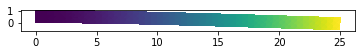

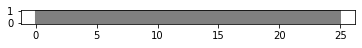

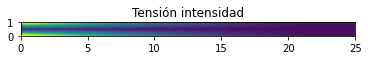

In [9]:
import matplotlib.pyplot as plt

plt.figure(1)
plot(1e2*u, mode="displacement")#

plt.figure(2)
plot(mesh)


s = sigma(u) - (1./3)*tr(sigma(u))*Identity(2)
von_Mises = sqrt(3./2*inner(s, s))
W = FunctionSpace(mesh, 'P', 1)#Ahora es un espacio escalar!
von_Mises = project(von_Mises, W)

plt.figure(3)
plot(von_Mises, title='Tensión intensidad')


plt.show()